# Anchors

The model-agnostic system explains the behavior of complex models with high-precision rules, called anchors, representing local, "sufficient" conditions for predictions.
A perturbation-based strategy is used to generate local explanations for predictions of black-box machine learning models, expressed as easy-to-understand IF-THEN rules.  
Given 
- a black box model $f: X \rightarrow Y$
- an instance $x \in X$
- a perturbation distribution $D$ of instance $x$

The rule $A$ (set of predicates) is an anchor $A$ if  
$$ E_{D_x (z|A)}[1_{f(x)=f(z)}] \geq \tau \text{ and }  A(x)=1$$

Since constructing particular rules is infeasible, a probabilistic definition is used:  
Given the coverage as  
$$ cov(A) = E_{D(z)}[A(z)] $$  
and the precision as  
$$ prec(A) = E_{D(z|A)}[1_{f(x)=f(z)}] , $$  
the goal is to find   
$$ \max_{A s.t. P(prec(A) \geq \tau) \geq 1- \delta} cov(A). $$  
Thus, one strives for a rule that has the highest coverage among all eligible rules.

**Literature**

Marco Tulio Ribeiro, Sameer Singh, Carlos Guestrin. “Anchors: High-Precision Model-Agnostic Explanations.” AAAI Conference on Artificial Intelligence (AAAI), 2018

In [1]:
import logging
import numpy as np
import seaborn as sn
import config
import matplotlib.pyplot as plt
import pandas as pd
import sloth
logger = logging.getLogger('sloth')
logger.setLevel(level=logging.DEBUG)

pd.set_option('display.max_colwidth', None)

sn.set_style("whitegrid")

%matplotlib inline
%load_ext autoreload
%autoreload 2


def plot_data(task):
    selection = task.data[validation_task.y_pred,:]
    plt.plot(selection[:,0], selection[:,1],'o', label='True')
    selection = task.data[~task.y_pred,:]
    plt.plot(selection[:,0], selection[:,1],'o', label='False')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.legend()

/home/doeltz/doeltz/development/RiVaPy/rivapy/__init__.py:11: UserWarning: The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.
  warnings.warn('The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.')


## Ordinal Values

### Data Overview

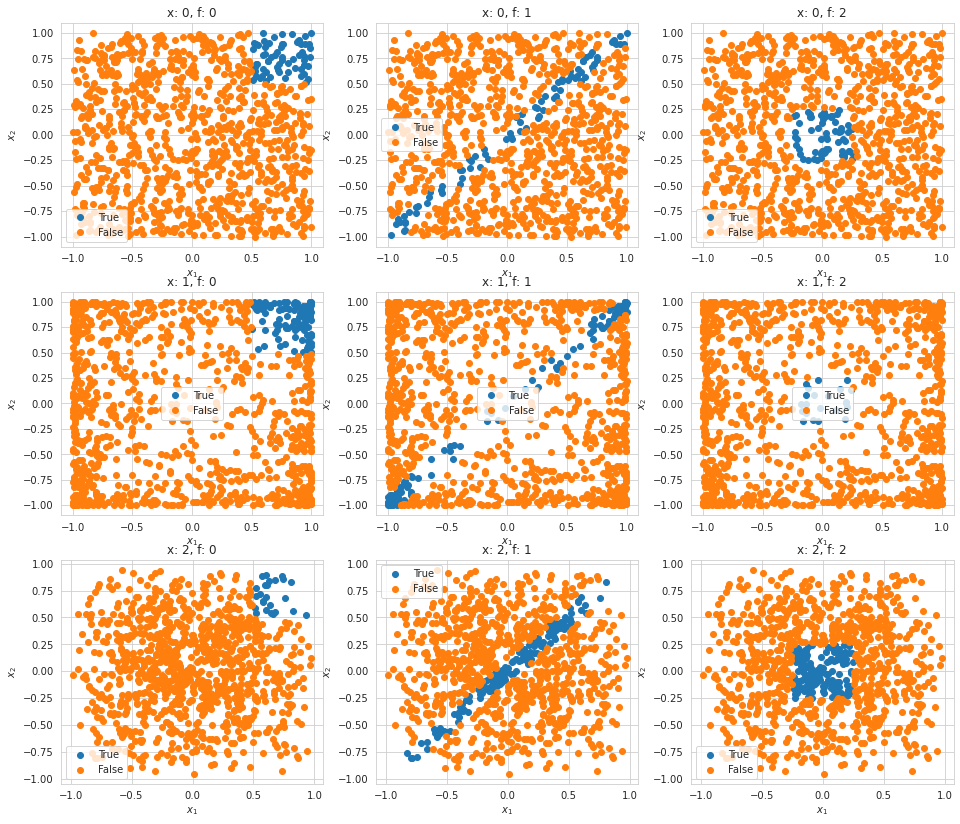

In [4]:
plt.figure(figsize=(16,14))

for i in range(3):
    for j in range(3):
        validation_task = sloth.datasets.test_sets.simple_classification_ordinal(n_samples=1_000, x=i, f=j)
        plt.subplot(3,3,i*3+j+1)
        plot_data(validation_task)
        plt.title('x: ' + str(i) + ', f: ' + str(j))

### Anchors

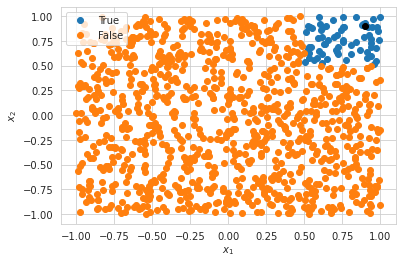

In [5]:
# get a sample validation task from a synthetic credit default model
validation_task = sloth.datasets.test_sets.simple_classification_ordinal(n_samples=1_000, x=0, f=0)
selection = validation_task.data[validation_task.y_pred,:]
plt.plot(selection[:,0], selection[:,1],'o', label='True')
selection = validation_task.data[~validation_task.y_pred,:]
plt.plot(selection[:,0], selection[:,1],'o', label='False')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

p = np.where(validation_task.y_pred==True)[0][0]
plt.plot(validation_task.data[p,0], validation_task.data[p,0], 'ok')
plt.legend();

Fragestellungen
- Wie wirkt sich die Diskretisierung der kontinuierlichen Werte aus? Warum erhält man je nach Verteilung unterschiedliche Anchor ? ( das liegt an den percentilen)
- Wie sieht der Anchor an Punkten, die mit False klassifiziert wurden, aus? Was könnte der Grund für einen solchen Anchor sein?
- Was geschieht, wenn man das 75% Quantil auf 70% setzt?

In [6]:
anchors = sloth.explainers.local_explainers.anchors.AnchorsAlibi(validation_task, 
                                                                 percentiles=[25,50,60],
                                                                 #percentiles=[k for k in range(5,100,2)],
                                                                 beam_size=10
                                                                )
anchors.explain(x=validation_task.data[p])

TypeError: AnchorsAlibi._explain() missing 1 required positional argument: 'predict'

In [4]:
anchors = sloth.explainers.local_explainers.anchors.AnchorsExp(validation_task, 
                                                                 discretizer='decile'
                                                                )
anchors.explain(x=validation_task.data[p])

,anchor,precision,coverage,point,target
0,x_2 > 0.79 AND x_1 > 0.61,1.0,0.018,"[0.8977710745066665, 0.9312640661491187, 0.6167946962329223]",[True]


## Ordinal and Categoric

In [5]:
# get a sample validation task from a synthetic credit default model
validation_task_categorical = sloth.datasets.test_sets.simple_classification_ordinal_categorical(n_samples=1_000)

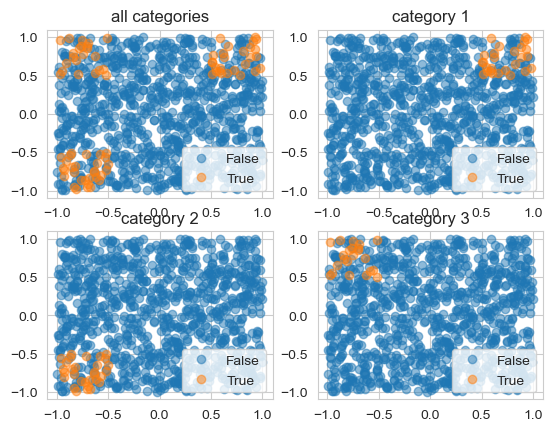

In [6]:
x = validation_task_categorical.data
for i in range(4):
    plt.subplot(2,2,i+1)
    if i==0:
        selection = x[validation_task_categorical.y_pred==0,:]
        plt.plot(selection[:,0], selection[:,4],'o', label='False', alpha=0.5)
        selection = x[validation_task_categorical.y_pred==1,:]
        plt.plot(selection[:,0], selection[:,4],'o', label='True', alpha=0.5)
        plt.title('all categories')
    else:
        selection = (x[:,i]==1)&(validation_task_categorical.y_pred==1)
        plt.plot(x[~selection,0], x[~selection,4],'o', label='False', alpha=0.5)
        plt.plot(x[selection,0], x[selection,4],'o', label='True', alpha=0.5) 
        plt.title('category ' + str(i))
    plt.legend();

In [8]:
anchors = sloth.explainers.local_explainers.anchors.AnchorsAlibi(validation_task_categorical, 
                                                                 percentiles=[12.0,25.0,50.0,75.0],
                                                                 #percentiles=[k for k in range(5,100,2)],
                                                                 beam_size=10
                                                                )
anchors.explain(x=validation_task_categorical.data[p])

,anchor,precision,coverage,point,target
0,x_5 > 0.52 AND categorical = category 1 AND x_1 > 0.49,0.992188,0.0232,"[0.9398197043239886, 1.0, 0.0, 0.0, 0.975336015993294]",[1.0]


In [11]:
x = validation_task_categorical.data
point = np.where((x[:,0]>0.5)&(x[:,4]>0.5)&(validation_task_categorical.y_pred==1))[0][0]
anchors.explain(x=x[point])

,anchor,precision,coverage,point,target
0,x_5 > 0.52 AND categorical = category 1 AND x_1 > 0.49,0.992188,0.0232,"[0.9398197043239886, 1.0, 0.0, 0.0, 0.975336015993294]",[1.0]
